This notebook compares three methods for computing or approximating the ELPD:
- Full leave-one-out cross-validation (LOO-CV)
- Pareto-smoothed importance sampling LOO-CV (PSIS-LOO-CV)
- The approximation of the ELPD using the WAIC

In [277]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import xarray
import sys
from scipy.stats import mode

sys.path.append("../models/")
from shin_2014 import *

jax.config.update("jax_enable_x64", True)

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

################ LOAD in DATA ################
savedir = '../../../results/MAPK/param_est/HF96_synthetic_data/'

# load in the model info 
model = 'shin_2014'
model_info = json.load(open('model_info.json', 'r'))[model]
display_name = "S' 2014"

idata_old, _ = load_smc_samples_to_idata(savedir+model+'/'+model+'_smc_samples.json', sample_time=False)
posterior_samples = np.load(savedir+model+'/'+model+'_posterior_predictive_samples.npy')


# get training and testing data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']


In [188]:
def build_pymc_model_mutable_data(prior_param_dict, data, y0_EGF_inputs, 
                    output_states, max_time, model_dfrx_ode, model=None, 
                    simulator=ERK_stim_response, data_sigma=0.1):
    """ Builds a pymc model object for the MAPK models.

    Constructs priors for the model, and uses the ERK_stim_response function to 
    generate the stimulus response function and likelihood.
    """

    
    # Create jax functions to solve # 
    def sol_op_jax(y0, *params):
        pred, _ = simulator(params, model_dfrx_ode, max_time, y0, output_states)
        return jnp.vstack((pred))

    # get the jitted versions
    sol_op_jax_jitted = jax.jit(sol_op_jax)
    
    # Create pytensor Op and register with jax # 
    class StimRespOp(Op):
        def make_node(self, *inputs):
            # Convert our inputs to symbolic variables
            inputs = [pt.as_tensor_variable(inp) for inp in inputs]
            # Assume the output to always be a float64 matrix
            outputs = [pt.matrix()]
            return Apply(self, inputs, outputs)

        def perform(self, node, inputs, outputs):
            result = sol_op_jax_jitted(*inputs)
            outputs[0][0] = np.asarray(result, dtype="float64")
        
        def grad(self, inputs, output_grads):
            raise NotImplementedError("PyTensor gradient of StimRespOp not implemented")


    # construct Ops and register with jax_funcify
    sol_op = StimRespOp()

    @jax_funcify.register(StimRespOp)
    def sol_op_jax_funcify(op, **kwargs):
        return sol_op_jax
    
    inp_idxs = np.linspace(0, len(data), len(data), dtype=int)
    # Construct the PyMC model # 
    model = pm.Model()
    with model:
        model.add_coord("stim", np.arange(len(inputs)), mutable=True)
        model.add_coord("state", np.arange(len(np.array(y0))), mutable=False)
        model.add_coord("ERK", np.array([1.0]), mutable=False)
        ins = pm.MutableData('inputs', y0_EGF_inputs, dims=("stim", "state"))
        y_obs = pm.MutableData('y_obs', data, dims=("stim", "ERK"))
        
        # loop over free params and construct the priors
        priors = [ins]
        for key, value in prior_param_dict.items():
            # create PyMC variables for each parameters in the model

            prior = eval(value)
            priors.append(prior)

        # predict dose response
        prediction = sol_op(*priors)

        # assume a normal model for the data
        # sigma specified by the data_sigma param to this function
        llike = pm.Normal("y", mu=prediction, sigma=data_sigma, observed=y_obs, dims=("stim","ERK"),)

    return model, sol_op_jax_jitted

#### Build PyMC model for S' 2014
This repeats code that is in `inference_process_dose_response.ipynb` to build the PyMC model for S' 2014.

In [189]:
model_func = eval(model + '(transient=False)')

# get parameter names and initial conditions
p_dict, plist = model_func.get_nominal_params()
y0_dict, y0 = model_func.get_initial_conditions()

# convert EGF to required units
inputs_native_units = inputs * float(model_info['EGF_conversion_factor'])

# get the params to sample
analyze_params = model_info['free_params'].split(',')
free_param_idxs = [list(p_dict.keys()).index(p) for p in analyze_params]

data_sigma = 0.1

# get the EGF index and ERK indices
state_names = list(y0_dict.keys())
EGF_idx = state_names.index(model_info['input_state'])
ERK_indices = [state_names.index(s) for s in model_info['ERK_states'].split(',')]

# construct the strings to make priors and constants
prior_param_dict = set_prior_params(model, list(p_dict.keys()), plist, free_param_idxs,
                                    upper_mult=100, lower_mult=0.01,prior_family=model_info['prior_family'], saveplot=False, savedir=None)
plt.close('all')

# make initial conditions that reflect the inputs
y0_EGF_ins = construct_y0_EGF_inputs(inputs_native_units, np.array([y0]), EGF_idx)

# simulator function
if model_info['ss_method'] == 'ode':
    event_rtol = float(model_info['event_rtol'])
    event_atol = float(model_info['event_atol'])
elif model_info['ss_method'] == 'newton':
    event_rtol = float(model_info['newton_event_rtol'])
    event_atol = float(model_info['newton_event_atol'])

print('Using {} for SS with tols atol={}, rtol={}.'.format(model_info['ss_method'], event_atol, event_rtol))
simulator = lambda params, model_dfrx_ode, max_time, y0_EGF_inputs, \
    output_states: ERK_stim_response(params, model_dfrx_ode, max_time, y0_EGF_inputs, 
                    output_states, event_rtol=event_rtol, event_atol=event_atol,
                    rtol=float(model_info['rtol']), atol=float(model_info['atol']), ode_or_newton=model_info['ss_method'])


# construct the pymc model
pymc_model, sol_op_jax_jitted = build_pymc_model_mutable_data(prior_param_dict, data, y0_EGF_ins, 
                ERK_indices, jnp.inf, diffrax.ODETerm(model_func), simulator=simulator)

ERK_tot 22.6 0.0022600000000000003
pm.LogNormal("ERK_tot",sigma=2.349619800594078, mu=-1.487220279709851, )
ki39 0.07716 7.716e-06
pm.LogNormal("ki39",sigma=2.349619800594078, mu=-7.1670442769327005, )
kd39 16.16 0.001616
pm.LogNormal("kd39",sigma=2.349619800594077, mu=-1.822631132895142, )
kc41 5073.0 0.5073
pm.LogNormal("kc41",sigma=2.349619800594078, mu=3.9265174515785985, )
kc43 466.3 0.046630000000000005
pm.LogNormal("kc43",sigma=2.349619800594078, mu=1.539659017826184, )
kc45 6.872 0.0006872
pm.LogNormal("kc45",sigma=2.349619800594077, mu=-2.677715001306137, )
kc47 39.050000000000004 0.003905
pm.LogNormal("kc47",sigma=2.349619800594077, mu=-0.9403273097023963, )
Using newton for SS with tols atol=1e-06, rtol=1e-06.


In [285]:
# first set up dictionary of kwargs for the sampling function
sample_kwargs = {
    "draws": 1000,
    "cores": 1,
    "chains": 4,
    "progressbar": True,
    "threshold": 0.5,
    "correlation_threshold": 0.01,
    "idata_kwargs": {'log_likelihood': True},
}

# Run the sampler again
with pymc_model:
        idata = pm.sample_smc(
            **sample_kwargs,
        )

Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


(-0.35000000000000003, 7.35)

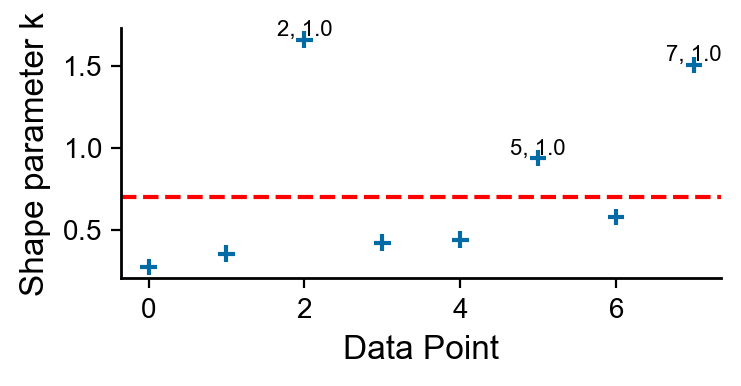

In [314]:
psis_loo_cv = az.loo(idata, pointwise=True)
waic = az.waic(idata, pointwise=True)
# print(psis_loo_cv)
# make shape parameter plot
fig, ax = get_sized_fig_ax(3, 1.25)
az.plot_khat(psis_loo_cv, ax=ax, threshold=0.7)
xlim = ax.get_xlim()
ax.plot(xlim, [0.7, 0.7], 'r--')
ax.set_xlim(xlim)

#### Use Arviz reloo to recompute the LOO-CV estimate by resampling the model with the appropriate held-out data points
We will do this two ways:
1. Only refitting for the *problematic* data points, the data points with a shape parameter $k$ that is greater than 0.7
2. Performing a full LOO-CV, refitting with each held-out data point

##### Custom Arviz PyMC SamplingWrapper
The original Arviz wrapper does not allow use of SMC sampling. This notebook provides a custom wrapper that allows for SMC sampling.

In [292]:
from scipy import stats
from xarray_einstats.stats import XrContinuousRV


class PyMC_ODE_Wrapper(az.PyMCSamplingWrapper):
    def sample(self, modified_observed_data):
        """Update data and sample model on modified_observed_data."""
        import pymc  # pylint: disable=import-error

        # The original Arviz PyMC wrapper used the pm.sample() function which
        #   does not perform SMC sampling.
        with self.model:
            # from https://python.arviz.org/en/v0.17.1/user_guide/pymc_refitting.html
            # if the model had coords the dim needs to be updated before
            # modifying the data in the model with set_data
            # otherwise, we don't need to overwrite the sample method
            n__i = len(modified_observed_data["inputs"])
            self.model.set_dim("stim", n__i, coord_values=np.arange(n__i))

            pymc.set_data(modified_observed_data)
            # idata = pymc.sample(
            #     **self.sample_kwargs,
            # )
            # use the SMC sampling function
            idata = pymc.sample_smc(
                **self.sample_kwargs,
            )

        return idata

    def log_likelihood__i(self, excluded_observed_data, idata__i):
        post = idata__i.posterior
        names = list(idata.posterior.data_vars.keys())
        print(names)
        post_param_vals = np.array([post[param] for param in post.data_vars])
        nvars,nchains,nsamples = post_param_vals.shape
        post_param_vals = post_param_vals.reshape(nvars,nchains*nsamples).T
        
        preds = []
        for psample in post_param_vals:
            pdict = p_dict.copy()
            for i, param in enumerate(psample):
                pdict[names[i]] = param
            params = list(pdict.values())

            
            preds.append(sol_op_jax_jitted(jnp.array(excluded_observed_data["inputs"]), *params))
            
        preds = np.squeeze(np.array(preds))
        
        preds = preds.reshape(nchains, nsamples, len(excluded_observed_data["inputs"]))
        preds = xarray.DataArray(preds, dims=("chain", "draw", "stim"))


        
        dist = XrContinuousRV(
            stats.norm,
            preds,
            data_sigma,
        )
        return dist.logpdf(excluded_observed_data["y_obs"])

    def sel_observations(self, idx):
        xdata = self.idata_orig["constant_data"]["inputs"]
        ydata = self.idata_orig["observed_data"]["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        data_dict = {"inputs": xdata, "y_obs": ydata}
        data__i = {key: value.values[~mask] for key, value in data_dict.items()}
        data_ex = {key: value.isel(stim=idx) for key, value in data_dict.items()}
        return data__i, data_ex
    

    def get_inference_data(self, fitted_model):
        """Return sampling result without modifying.

        PyMC sampling already returns and InferenceData object.
        """
        return fitted_model


In [293]:
sample_kwargs = {
    "draws": 1000,
    "cores": 1,
    "chains": 4,
    "progressbar": True,
    "threshold": 0.5,
    "correlation_threshold": 0.01,
    "idata_kwargs": {'log_likelihood': True}
}

# wrap the model
wrapped_model = PyMC_ODE_Wrapper(pymc_model, idata_orig=idata, sample_kwargs=sample_kwargs)

Perform full LOO-CV. Following https://python.arviz.org/en/v0.17.1/user_guide/pymc_refitting.html, we artificially set the k-shape parameter to above the 0.7 threshold to force refitting.

In [297]:
psis_loo_cv_modified = psis_loo_cv.copy()
psis_loo_cv_modified.pareto_k[:] = 1.0 # set all pareto k values to 1 so we perform full LOO-CV

loo_relooed_full = az.reloo(wrapped_model,  loo_orig=psis_loo_cv_modified, k_thresh=0.7)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


Initializing SMC sampler...
Sampling 4 chains in 1 job


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


['ERK_tot', 'ki39', 'kd39', 'kc41', 'kc43', 'kc45', 'kc47']


In [318]:
print('PSIS-LOO-CV estimated the ELPD as {} (with SE {})'.format(psis_loo_cv.elpd_loo, psis_loo_cv.se))
print('Full LOO-CV computed the ELPD as {} (with SE {})'.format(loo_relooed_full.elpd_loo, loo_relooed_full.se))
print('WAIC computed the ELPD as {} (with SE {})'.format(waic.elpd_waic, waic.se))

PSIS-LOO-CV estimated the ELPD as -5.694314762714856 (with SE 4.001329722867008)
Full LOO-CV computed the ELPD as -5.428435721107991 (with SE 6.715235483089525)
WAIC computed the ELPD as -2.741641545396009 (with SE 3.546477023542218)


In [322]:
results_df = pd.DataFrame({'LOO-CV methods': ['PSIS-LOO-CV', 'Full LOO-CV', 'WAIC'], 'ELPD': [psis_loo_cv.elpd_loo, loo_relooed_full.elpd_loo, waic.elpd_waic], 'SE': [psis_loo_cv.se, loo_relooed_full.se, waic.se]})
results_df.to_csv('../../../results/MAPK/param_est/HF96_synthetic_data/loo_cv_results.csv', index=False)

### Results
PSIS-LOO-CV and LOO-CV are very similar, despite some problematic data points (k > 0.7). The WAIC approximation is not as good.

In [323]:
results_df

,LOO-CV methods,ELPD,SE
0,PSIS-LOO-CV,-5.694315,4.001330
1,Full LOO-CV,-5.428436,6.715235
2,WAIC,-2.741642,3.546477
